### ETL using spark on the full dataset

In [1]:
%set_env OBJC_DISABLE_INITIALIZE_FORK_SAFETY=YES
import pyspark
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from pyspark.sql.types import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

env: OBJC_DISABLE_INITIALIZE_FORK_SAFETY=YES


### 0. load spark dataframe

In [2]:
SparkSession.builder.master("local[*]").getOrCreate().stop()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/15 20:46:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark = SparkSession \
        .builder \
        .enableHiveSupport() \
        .master('spark://192.168.0.103:7077') \
        .appName('etl-spark') \
        .getOrCreate()

In [4]:
# select only useful columns, filter out logged out user
df = spark.sql('''
                SELECT userId, userAgent, ts, status, sessionId, page, method, location, level, gender, auth, registration
                FROM json.`/Applications/spark-3.4.1-bin-hadoop3/work/sparkify_event_data.json`
                WHERE userId != "1261737"
               ''').repartition(10, 'userId').persist()

In [5]:
df.count()

25480720

In [6]:
print(type(df))

<class 'pyspark.sql.dataframe.DataFrame'>


### 1. get rid of nan

In [7]:
def value_counts(df, col):
    return df.groupby(col).count().sort(F.col('count').desc())

In [8]:
tmp = df.groupby('userId').agg(F.spark_partition_id()).toPandas()

In [9]:
tmp['SPARK_PARTITION_ID()'].value_counts()

SPARK_PARTITION_ID()
3    2297
0    2288
2    2276
4    2266
5    2251
8    2240
7    2182
9    2177
1    2166
6    2134
Name: count, dtype: int64

In [10]:
def num_nulls(df, col, empty_str=False):
    if empty_str:
        return df.select(F.count(F.when(F.col(col)=='1261737', 1)).alias(f"num_nulls_{col}"))
    else:
        return df.select(F.count(F.when(F.isnull(col), 1)).alias(f"num_nulls_{col}"))

In [11]:
def expand_cols(df, func):
    ''' apply func on all columns of df then concat to pd '''
    return pd.concat([func(df, c).toPandas() for c in df.columns], axis=1)

In [12]:
expand_cols(df, num_nulls).T

,0
num_nulls_userId,0
num_nulls_userAgent,0
num_nulls_ts,0
num_nulls_status,0
num_nulls_sessionId,0
num_nulls_page,0
num_nulls_method,0
num_nulls_location,0
num_nulls_level,0
num_nulls_gender,0


In [13]:
value_counts(df, 'page').show(truncate=False)

+-------------------------+--------+
|page                     |count   |
+-------------------------+--------+
|NextSong                 |20850272|
|Thumbs Up                |1151465 |
|Home                     |933124  |
|Add to Playlist          |597921  |
|Roll Advert              |385212  |
|Add Friend               |381664  |
|Logout                   |296005  |
|Thumbs Down              |239212  |
|Downgrade                |184240  |
|Settings                 |147074  |
|Help                     |129448  |
|Upgrade                  |50507   |
|About                    |48377   |
|Save Settings            |29516   |
|Error                    |25048   |
|Submit Upgrade           |15135   |
|Submit Downgrade         |6494    |
|Cancel                   |5003    |
|Cancellation Confirmation|5003    |
+-------------------------+--------+



In [14]:
df.columns

['userId',
 'userAgent',
 'ts',
 'status',
 'sessionId',
 'page',
 'method',
 'location',
 'level',
 'gender',
 'auth',
 'registration']

In [15]:
def sp_nunique(df, col):
    return df.select(F.count_distinct(col).alias(f"nunique_{col}"))

In [16]:
sp_nunique(df, 'page').show()

+------------+
|nunique_page|
+------------+
|          19|
+------------+



In [17]:
value_counts(df, 'auth').show()

+---------+--------+
|     auth|   count|
+---------+--------+
|Logged In|25475717|
|Cancelled|    5003|
+---------+--------+



### 2. define churn event

In [18]:
df = df.withColumn('churn', F.when(F.col('page')=='Cancellation Confirmation', 1).otherwise(0))

In [19]:
window = Window.partitionBy('userId').orderBy('ts').rowsBetween(Window.unboundedPreceding, Window.currentRow)
df = df.withColumn('churn_yet', F.max('churn').over(window))

In [20]:
df_feats = df.groupby('userId').agg(F.max('churn').alias('churn')).toPandas()
df_feats

,userId,churn
0,1662639,1
1,1090823,0
2,1321163,0
3,1839943,0
4,1331962,0
...,...,...
22272,1679128,0
22273,1105395,0
22274,1913790,0
22275,1480584,0


In [21]:
df_feats.churn.mean()

0.22458140683215874

#### make sure this cancel page is not leaked into the analysis

In [22]:
df = df.filter('(churn_yet = 0) AND (page != "Cancel")')

In [23]:
df.count()

23/07/15 20:49:19 WARN TaskSetManager: Lost task 3.0 in stage 90.0 (TID 392) (192.168.0.101 executor 0): org.apache.spark.memory.SparkOutOfMemoryError: [UNABLE_TO_ACQUIRE_MEMORY] Unable to acquire 65536 bytes of memory, got 0.
	at org.apache.spark.errors.SparkCoreErrors$.outOfMemoryError(SparkCoreErrors.scala:467)
	at org.apache.spark.errors.SparkCoreErrors.outOfMemoryError(SparkCoreErrors.scala)
	at org.apache.spark.memory.MemoryConsumer.throwOom(MemoryConsumer.java:157)
	at org.apache.spark.memory.MemoryConsumer.allocateArray(MemoryConsumer.java:98)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.growPointerArrayIfNecessary(UnsafeExternalSorter.java:384)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecessary(UnsafeExternalSorter.java:467)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:487)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.inse

25470714

### 3. make some features that stay the same over time

In [24]:
cols = df.columns
cols.remove('userId')
cols

['userAgent',
 'ts',
 'status',
 'sessionId',
 'page',
 'method',
 'location',
 'level',
 'gender',
 'auth',
 'registration',
 'churn',
 'churn_yet']

In [25]:
def get_static_features(df):
    return df.groupby('userId').agg(F.first('location').alias('location'),\
                                    F.first('userAgent').alias('agent'),\
                                    F.first('gender').alias('gender'),\
                                    F.first('registration').alias('registration')).toPandas()

In [26]:
tmp = get_static_features(df)
df_feats = pd.merge(df_feats, tmp, on='userId')

In [27]:
df_feats

,userId,churn,location,agent,gender,registration
0,1662639,1,"Oxnard-Thousand Oaks-Ventura, CA","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",M,1534024341000
1,1090823,0,"New York-Newark-Jersey City, NY-NJ-PA","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",M,1537927525000
2,1321163,0,"Birmingham-Hoover, AL","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",M,1537817518000
3,1839943,0,"Miami-Fort Lauderdale-West Palm Beach, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",F,1535904852000
4,1331962,0,"Edwards, CO",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,M,1536901904000
...,...,...,...,...,...,...
22272,1679128,0,"San Diego-Carlsbad, CA","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",F,1535979645000
22273,1105395,0,"Minneapolis-St. Paul-Bloomington, MN-WI","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",F,1529776594000
22274,1913790,0,"Chicago-Naperville-Elgin, IL-IN-WI","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",F,1533361992000
22275,1480584,0,"Los Angeles-Long Beach-Anaheim, CA",Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,M,1537029126000


In [28]:
# for referece, this is how to do it in pyspark side
# def convert_agent(c):
#     return F.when(F.col(c).contains('macintosh'), 'mac').\
#              when(F.col(c).contains('iphone'), 'iphone').\
#              when(F.col(c).contains('ipad'), 'ipad').\
#              when(F.col(c).contains('windows'), 'windows').\
#              when(F.col(c).contains('linux'), 'linux').\
#              otherwise('others')

In [28]:
def stack_and_ready_for_plot(df):
    num_cols = list(df.dtypes.index[df.dtypes != 'object'])
    df = df[num_cols]
    tmp = df.drop(columns=['churn']).stack().reset_index()
    tmp.columns = ['userId','parameter','val']
    tmp = tmp.join(df[['churn']], on='userId')
    return tmp

In [29]:
def convert_agent(x):
    x = x.lower()
    if 'macintosh' in x:
        return 'mac'
    elif 'iphone' in x:
        return 'iphone'
    elif 'ipad' in x:
        return 'ipad'
    elif 'windows' in x:
        return 'windows'
    elif 'linux' in x:
        return 'linux'
    else:
        return 'others'

In [30]:
df_feats['agent'] = df_feats.agent.apply(convert_agent)

<Axes: xlabel='agent', ylabel='Density'>

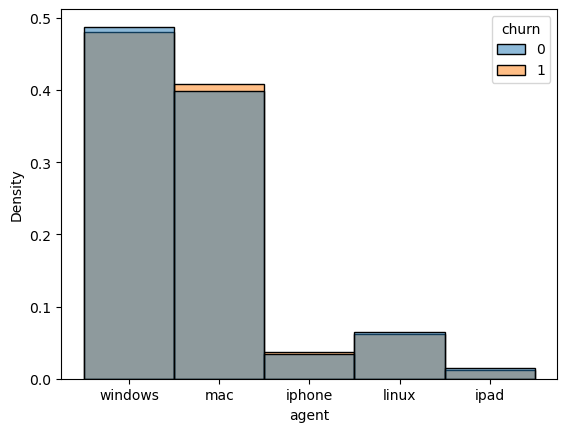

In [31]:
sns.histplot(df_feats, x='agent', hue='churn', common_norm=False, stat='density')

<Axes: xlabel='gender', ylabel='Density'>

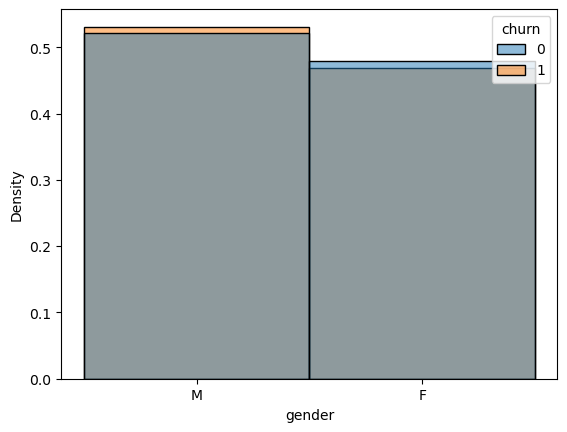

In [32]:
sns.histplot(df_feats, x='gender', hue='churn', common_norm=False, stat='density')

#### now this is similar to the smaller dataset!

### 4. get some features on page activity

In [33]:
actions = [x['page'] for x in df.select('page').distinct().collect()]
# actions.remove('Cancel')
actions

['Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

In [34]:
df.columns

['userId',
 'userAgent',
 'ts',
 'status',
 'sessionId',
 'page',
 'method',
 'location',
 'level',
 'gender',
 'auth',
 'registration',
 'churn',
 'churn_yet']

In [35]:
def get_features(df):
    
    g = df.groupby('userId')
    
    # get the total session time
    output = df.groupby('userId','sessionId').agg(((F.max('ts')-F.min('ts'))/3600/1000).alias('hour')).\
                groupby('userId').agg(F.sum('hour').alias('total_session_time')).toPandas()
    
    # total time and page counts
    tmp = g.agg(*[F.sum(F.when(F.col('page')==action, 1)).alias(action) for action in actions],
                  F.max('ts').alias('max_ts'),
                  F.min('ts').alias('min_ts'),
                  F.count_distinct('sessionId').alias('session_counts'),
                  F.count('*').alias('count'),
                  F.count(F.when(F.col('status')==307, 1)).alias('status_307_count'),   
                  F.count(F.when(F.col('method')=='GET', 1)).alias('get_count')).na.fill(0).toPandas()
    output = pd.merge(output, tmp, on='userId')
    output['total_time'] =  (output['max_ts'] - output['min_ts'])/3600./1000.
    
    # gap time
    output['avg_gap_time'] = (output['total_time'] - output['total_session_time']) / (output['session_counts'] - 1)
    output.loc[output.session_counts==1, 'avg_gap_time'] = 0.0
    output.drop(columns=['total_session_time', 'session_counts'], inplace=True)
    
    # normalize by count
    for action in actions:
        if action != 'NextSong':
            output[action] = output[action] / output['count']
    output.drop(columns=['NextSong'], inplace=True)
    output['status_307_count'] = output['status_307_count'] / output['count']
    output['get_count'] = output['get_count'] / output['count']
    
    # first and last level
    tmp = df.orderBy('userId','ts').groupby('userId').agg(F.first('level').alias('first_level'),
                                                          F.last('level').alias('last_level')).toPandas()
    output = pd.merge(output, tmp, on='userId')    
    
    return output

In [36]:
tmp = get_features(df)
tmp

,userId,Submit Downgrade,Thumbs Down,Home,Downgrade,Roll Advert,Logout,Save Settings,About,Settings,...,Submit Upgrade,max_ts,min_ts,count,status_307_count,get_count,total_time,avg_gap_time,first_level,last_level
0,1000103,0.000000,0.010526,0.084211,0.010526,0.031579,0.021053,0.000000,0.000000,0.000000,...,0.010526,1542769303000,1538674277000,95,0.084211,0.147368,1137.507222,377.637222,free,paid
1,1000214,0.000813,0.010167,0.039447,0.009760,0.012607,0.015860,0.000813,0.002033,0.005287,...,0.000813,1543612539000,1538564463000,2459,0.081334,0.077267,1402.243333,48.711335,paid,paid
2,1000280,0.000760,0.025095,0.033460,0.002281,0.056274,0.011407,0.000760,0.000000,0.006844,...,0.000760,1542149939000,1538428238000,1315,0.089734,0.114068,1033.805833,45.826336,free,free
3,1000611,0.000000,0.006211,0.037832,0.007340,0.019198,0.010164,0.003953,0.002259,0.009599,...,0.000565,1543612660000,1538602281000,1771,0.077922,0.084698,1391.771944,51.768144,free,paid
4,1000655,0.000000,0.007712,0.046272,0.000000,0.064267,0.025707,0.000000,0.002571,0.005141,...,0.000000,1543474947000,1538557259000,389,0.089974,0.128535,1366.024444,122.363005,free,free
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22272,1428880,0.000000,0.090909,0.090909,0.000000,0.030303,0.000000,0.000000,0.000000,0.030303,...,0.000000,1538670903000,1538664921000,33,0.121212,0.151515,1.661667,0.000000,free,free
22273,1836527,0.000000,0.016260,0.024390,0.000000,0.097561,0.016260,0.000000,0.000000,0.000000,...,0.000000,1542328327000,1542303705000,123,0.056911,0.162602,6.839444,0.000000,free,free
22274,1956587,0.000000,0.046512,0.023256,0.000000,0.069767,0.000000,0.000000,0.000000,0.023256,...,0.000000,1538405687000,1538397035000,43,0.069767,0.139535,2.403333,0.000000,free,free
22275,1979527,0.000000,0.000000,0.011111,0.055556,0.011111,0.000000,0.000000,0.000000,0.022222,...,0.000000,1538478229000,1538459477000,90,0.000000,0.122222,5.208889,0.000000,paid,paid


In [37]:
df_feats_tmp = pd.merge(df_feats, tmp, on='userId')

In [38]:
df_feats_tmp.columns

Index(['userId', 'churn', 'location', 'agent', 'gender', 'registration',
       'Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert',
       'Logout', 'Save Settings', 'About', 'Settings', 'Add to Playlist',
       'Add Friend', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade',
       'max_ts', 'min_ts', 'count', 'status_307_count', 'get_count',
       'total_time', 'avg_gap_time', 'first_level', 'last_level'],
      dtype='object')

(0.0, 0.2)

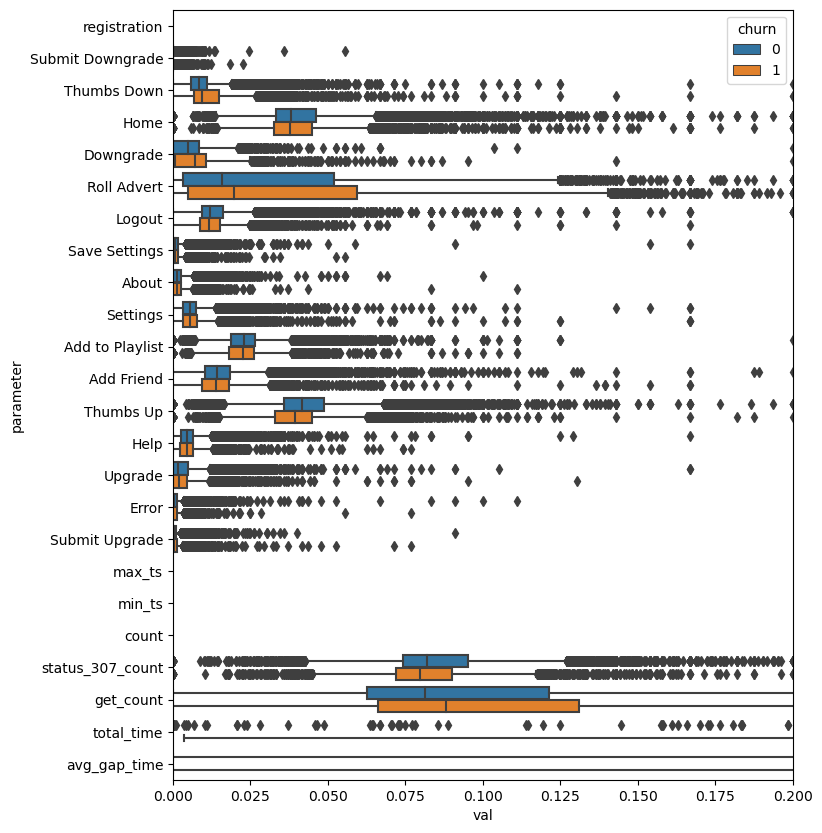

In [39]:
plt.figure(figsize=(8,10))
tmp = stack_and_ready_for_plot(df_feats_tmp)
sns.boxplot(tmp, x='val', y='parameter', hue='churn')
plt.xlim([0,0.2])

(1500000000000.0, 1560000000000.0)

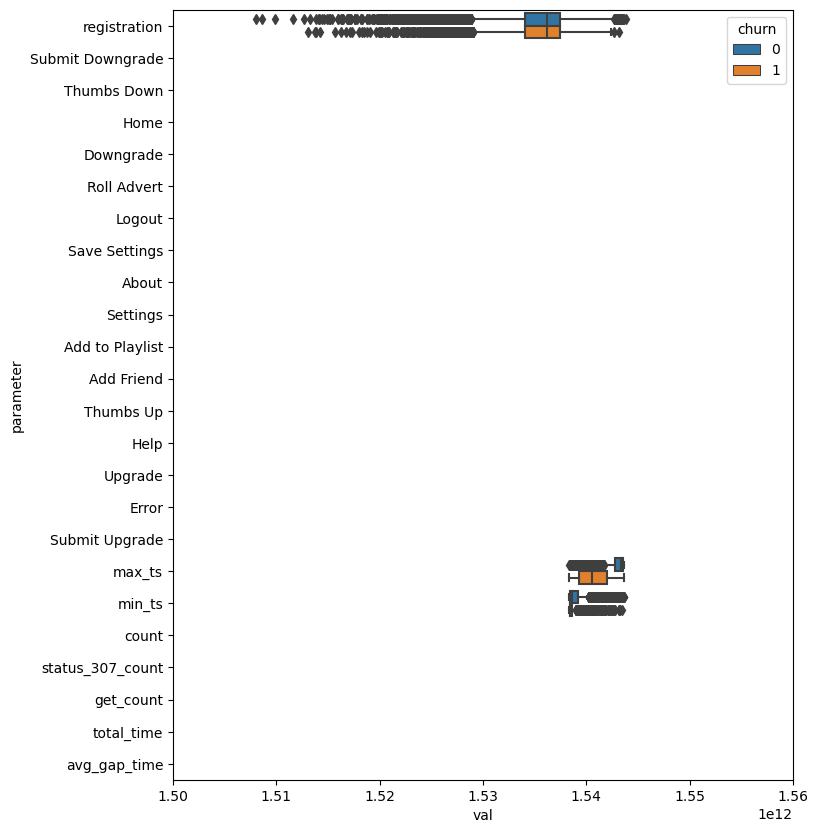

In [47]:
plt.figure(figsize=(8,10))
tmp = stack_and_ready_for_plot(df_feats_tmp)
sns.boxplot(tmp, x='val', y='parameter', hue='churn')
plt.xlim([1.5e12, 1.56e12])

(0.0, 2000.0)

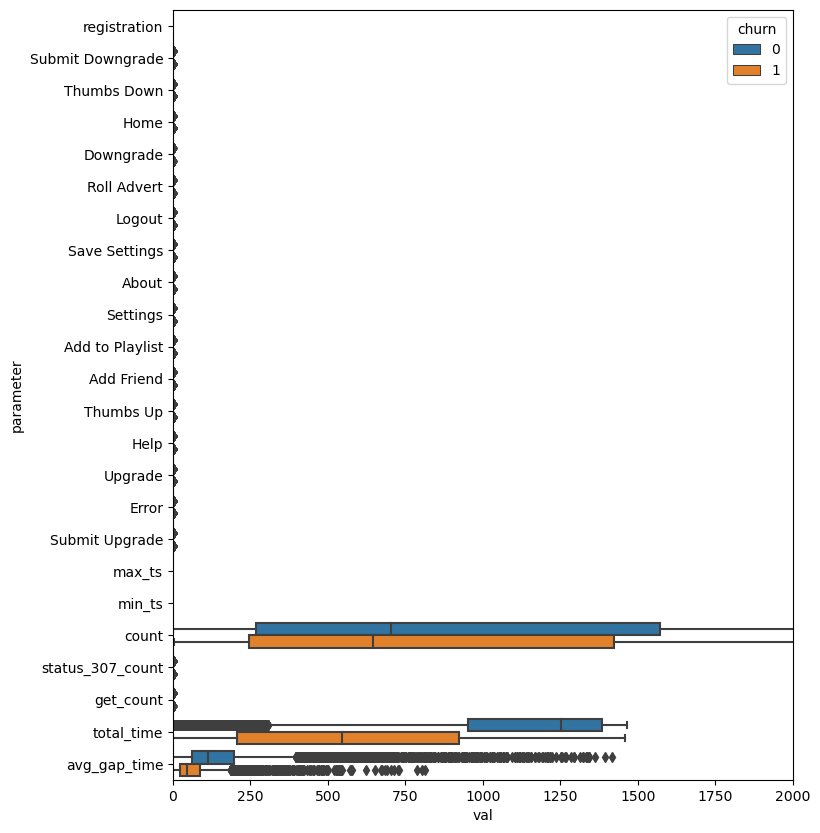

In [49]:
plt.figure(figsize=(8,10))
tmp = stack_and_ready_for_plot(df_feats_tmp)
sns.boxplot(tmp, x='val', y='parameter', hue='churn')
plt.xlim([0,2000])

#### this is very similar to random userId test

In [50]:
df_feats_tmp.drop(columns=['location', 'agent','gender']).corrwith(df_feats_tmp.churn, method='spearman').sort_values()

max_ts             -0.573977
total_time         -0.455477
avg_gap_time       -0.350869
min_ts             -0.237075
Thumbs Up          -0.123436
status_307_count   -0.082676
Logout             -0.047185
Add to Playlist    -0.029107
count              -0.028558
Add Friend         -0.025146
About              -0.024900
Home               -0.024731
Help               -0.018495
Save Settings      -0.013167
registration       -0.007988
Error              -0.006835
Upgrade            -0.003566
userId             -0.003206
Submit Downgrade    0.005652
Settings            0.025250
first_level         0.028273
Roll Advert         0.060596
Submit Upgrade      0.061488
get_count           0.077831
last_level          0.078247
Thumbs Down         0.107626
Downgrade           0.142159
churn               1.000000
dtype: float64

In [51]:
window = Window.partitionBy('userId')
df = df.withColumn('recent', (0.8*F.max('ts').over(window)+0.2*F.min('ts').over(window)))

In [52]:
df.select(F.mean(F.when(F.col('ts')>F.col('recent'),1).otherwise(0))).show()

+----------------------------------------------+
|avg(CASE WHEN (ts > recent) THEN 1 ELSE 0 END)|
+----------------------------------------------+
|                           0.25170338766318057|
+----------------------------------------------+



In [53]:
df_recent = df.filter(F.col('ts')>F.col('recent'))

In [54]:
tmp = get_features(df_recent)
tmp = tmp.drop(columns=['first_level','last_level', 'max_ts', 'min_ts'])
tmp

,userId,Submit Downgrade,Thumbs Down,Home,Downgrade,Roll Advert,Logout,Save Settings,About,Settings,...,Thumbs Up,Help,Upgrade,Error,Submit Upgrade,count,status_307_count,get_count,total_time,avg_gap_time
0,1000103,0.0,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.100000,0.050000,0.000000,0.000000,0.000000,20,0.100000,0.150000,0.835000,0.000000
1,1000214,0.0,0.012837,0.029525,0.006418,0.012837,0.016688,0.000000,0.000000,0.003851,...,0.042362,0.003851,0.001284,0.001284,0.001284,779,0.083440,0.059050,239.629167,32.861667
2,1000280,0.0,0.026882,0.037634,0.000000,0.053763,0.005376,0.000000,0.000000,0.010753,...,0.059140,0.000000,0.005376,0.005376,0.000000,186,0.091398,0.112903,178.057222,55.863148
3,1000611,0.0,0.008264,0.035813,0.011019,0.000000,0.012397,0.004132,0.001377,0.013774,...,0.035813,0.005510,0.000000,0.001377,0.000000,726,0.068871,0.068871,153.026389,37.270741
4,1000655,0.0,0.023256,0.000000,0.000000,0.069767,0.000000,0.000000,0.000000,0.000000,...,0.046512,0.023256,0.000000,0.000000,0.000000,43,0.116279,0.093023,210.136667,208.025833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22256,1996360,0.0,0.014103,0.026923,0.000000,0.000000,0.006410,0.001282,0.001282,0.003846,...,0.039744,0.002564,0.000000,0.000000,0.000000,780,0.073077,0.034615,225.118889,88.806250
22257,1997883,0.0,0.000000,0.065934,0.000000,0.000000,0.010989,0.010989,0.000000,0.021978,...,0.054945,0.010989,0.000000,0.000000,0.000000,91,0.087912,0.098901,5.198889,0.000000
22258,1998502,0.0,0.010417,0.083333,0.000000,0.010417,0.052083,0.000000,0.010417,0.020833,...,0.041667,0.000000,0.000000,0.000000,0.000000,96,0.125000,0.125000,119.393333,28.780417
22259,1999455,0.0,0.083333,0.166667,0.000000,0.083333,0.083333,0.000000,0.083333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,12,0.333333,0.333333,0.426944,0.000000


In [55]:
df_feats_tmp_change = pd.merge(df_feats_tmp, tmp, on='userId', suffixes=['','_recent'])
df_feats_tmp_change

,userId,churn,location,agent,gender,registration,Submit Downgrade,Thumbs Down,Home,Downgrade,...,Thumbs Up_recent,Help_recent,Upgrade_recent,Error_recent,Submit Upgrade_recent,count_recent,status_307_count_recent,get_count_recent,total_time_recent,avg_gap_time_recent
0,1662639,1,"Oxnard-Thousand Oaks-Ventura, CA",windows,M,1534024341000,0.000399,0.008112,0.035372,0.011037,...,0.036298,0.004840,0.0,0.00242,0.0,1653,0.071990,0.076830,218.820833,11.482753
1,1090823,0,"New York-Newark-Jersey City, NY-NJ-PA",windows,M,1537927525000,0.000000,0.006814,0.028109,0.009370,...,0.038986,0.000000,0.0,0.00000,0.0,513,0.066277,0.038986,235.403056,51.081319
2,1321163,0,"Birmingham-Hoover, AL",windows,M,1537817518000,0.000000,0.008943,0.032088,0.005260,...,0.047002,0.009724,0.0,0.00000,0.0,617,0.076175,0.047002,280.317500,80.715741
3,1839943,0,"Miami-Fort Lauderdale-West Palm Beach, FL",mac,F,1535904852000,0.000678,0.006784,0.044776,0.000678,...,0.031447,0.000000,0.0,0.00000,0.0,159,0.088050,0.113208,153.583056,48.526852
4,1331962,0,"Edwards, CO",windows,M,1536901904000,0.000000,0.011004,0.031637,0.009629,...,0.047753,0.014045,0.0,0.00000,0.0,356,0.084270,0.061798,208.947778,94.525000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22256,1679128,0,"San Diego-Carlsbad, CA",mac,F,1535979645000,0.000000,0.000000,0.044118,0.000000,...,0.000000,0.000000,0.0,0.00000,0.0,11,0.090909,0.181818,0.553056,0.000000
22257,1105395,0,"Minneapolis-St. Paul-Bloomington, MN-WI",windows,F,1529776594000,0.000000,0.015385,0.061538,0.000000,...,0.083333,0.000000,0.0,0.00000,0.0,12,0.166667,0.083333,0.691111,0.000000
22258,1913790,0,"Chicago-Naperville-Elgin, IL-IN-WI",mac,F,1533361992000,0.000000,0.000000,0.039683,0.000000,...,0.038462,0.000000,0.0,0.00000,0.0,26,0.115385,0.000000,1.228333,0.000000
22259,1480584,0,"Los Angeles-Long Beach-Anaheim, CA",mac,M,1537029126000,0.010000,0.040000,0.030000,0.020000,...,0.000000,0.000000,0.0,0.00000,0.0,29,0.103448,0.068966,1.246667,0.000000


(0.0, 0.2)

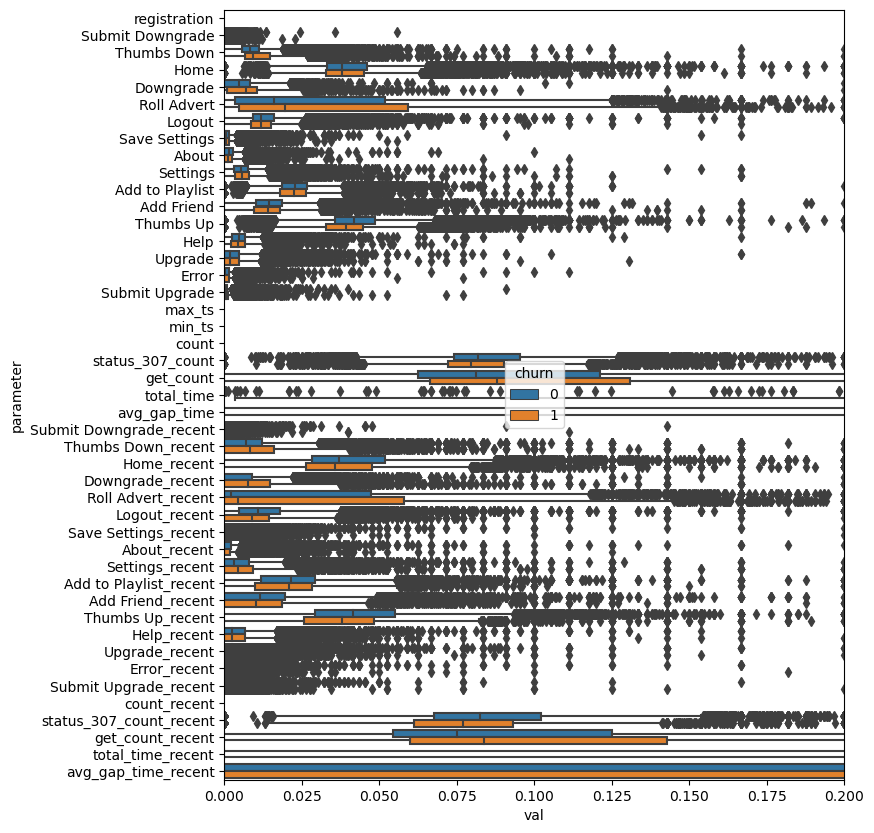

In [56]:
plt.figure(figsize=(8,10))
tmp = stack_and_ready_for_plot(df_feats_tmp_change)
sns.boxplot(tmp, x='val', y='parameter', hue='churn')
plt.xlim([0,0.2])

In [57]:
df_feats_tmp_change.shape

(22261, 52)

In [58]:
df_feats_tmp_change.columns

Index(['userId', 'churn', 'location', 'agent', 'gender', 'registration',
       'Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert',
       'Logout', 'Save Settings', 'About', 'Settings', 'Add to Playlist',
       'Add Friend', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade',
       'max_ts', 'min_ts', 'count', 'status_307_count', 'get_count',
       'total_time', 'avg_gap_time', 'first_level', 'last_level',
       'Submit Downgrade_recent', 'Thumbs Down_recent', 'Home_recent',
       'Downgrade_recent', 'Roll Advert_recent', 'Logout_recent',
       'Save Settings_recent', 'About_recent', 'Settings_recent',
       'Add to Playlist_recent', 'Add Friend_recent', 'Thumbs Up_recent',
       'Help_recent', 'Upgrade_recent', 'Error_recent',
       'Submit Upgrade_recent', 'count_recent', 'status_307_count_recent',
       'get_count_recent', 'total_time_recent', 'avg_gap_time_recent'],
      dtype='object')

In [59]:
df_feats_tmp_change.to_csv('data/df_feats_assembled.csv', index=False)

In [60]:
!ls -lht data/df_feats_assembled.csv

-rw-r--r--  1 zma  staff    15M Jul 15 21:00 data/df_feats_assembled.csv


In [61]:
spark.stop()